In [435]:
# %pip install numpy
# %pip install "dask[complete]"
# %pip install "dask[distributed]"

In [436]:
import numpy as np
np.set_printoptions(threshold=np.inf)
from multiprocessing import cpu_count
from time import time
from dask import delayed

import matplotlib.pyplot as plt 

In [437]:
MAX_UNITS = cpu_count()
MAX_X = 1024
MAX_Y = 1024
vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32)

In [438]:
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#

def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

In [439]:
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#

def vecinos(x,y,vector):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]

In [440]:
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas 
# vivirán y cuales no 
#
def conway(low_limit=0, high_limit=MAX_X, index=0):
    result_slice = np.empty((high_limit - low_limit) * MAX_Y, dtype=np.int32)

    for i in range(low_limit, high_limit):
        for j in range(0, MAX_Y):
            n = vecinos(i, j, vector)
            valor = 0
            if vector[indice(i, j)] == 1 and (n == 2 or n == 3):
                valor = 1
            elif vector[indice(i, j)] == 0 and n == 3:
                valor = 1
            result_slice[indice(i - low_limit, j)] = valor
    
    return [result_slice, index]


In [441]:
def conwayV2(low_limit = 0, high_limit = MAX_X):
    for i in range(low_limit,high_limit):
        for j in range(0,MAX_Y):
            n = vecinos(i,j, vector)
            valor = 0
            if vector[ indice(i,j) ] == 1 and (n == 2 or n == 3):
                valor = 1
            elif vector[ indice(i,j) ] == 0 and n == 3:
                valor = 1
            vector_out[ indice(i,j) ] = valor

/home/codespace/.python/current/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46399 instead
  warnings.warn(


El tiempo que tomó calcular 12.603736877441406


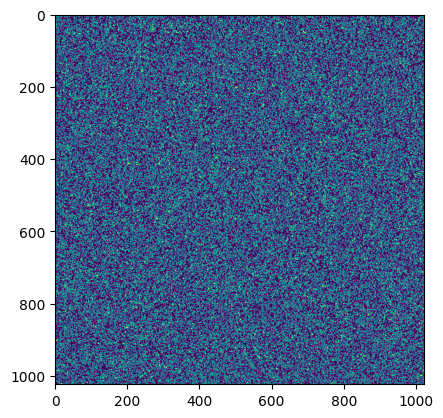

In [442]:
# Usando cliente de Dask

from dask.distributed import Client, LocalCluster
client = Client()
stride = np.int32(MAX_X / MAX_UNITS)
count = np.int32(0)
nodes = [] # arreglo que almacenará aquellos nodos que se ejecutan
for t in range(MAX_UNITS):
    node = delayed(conway)(count, np.int32(count + stride), t)
    nodes.append(node)
    count = count + stride

t1 = time()
results = client.compute(nodes)
results = client.gather(results)
sorted_results = sorted(results, key=lambda x: x[1])

sorted_data_lists = [result[0] for result in sorted_results]
vector_out = np.concatenate(sorted_data_lists)
    
t2 = time()
print(f"El tiempo que tomó calcular {t2 - t1}")
fig = plt.figure()
plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
plt.show()  
client.close()

El tiempo que tomó calcular 15.717669486999512


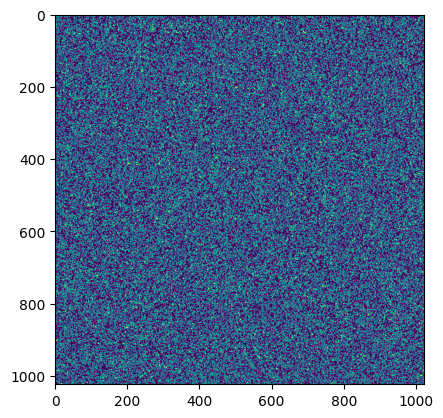

In [443]:
# Usando solo delayed

stride = np.int32(MAX_X / MAX_UNITS)
count = np.int32(0)
nodes = [] # arreglo que almacenará aquellos nodos que se ejecutan
for t in range(MAX_UNITS):
    node = delayed(conwayV2)(count, np.int32(count + stride))
    nodes.append(node)
    count = count + stride

t1 = time()
for node in nodes:
    node.compute()
t2 = time()
print(f"El tiempo que tomó calcular {t2 - t1}")
fig = plt.figure()
plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
plt.show()  
client.close()

/home/codespace/.python/current/lib/python3.10/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+-------------+-----------------+-----------------+-----------------+
| Package     | Client          | Scheduler       | Workers         |
+-------------+-----------------+-----------------+-----------------+
| dask        | 2023.12.0       | 2023.11.0       | 2023.11.0       |
| distributed | 2023.12.0       | 2023.11.0       | 2023.11.0       |
| msgpack     | 1.0.7           | 1.0.6           | 1.0.6           |
| numpy       | 1.26.2          | 1.26.0          | 1.26.0          |
| pandas      | 2.1.3           | 2.1.2           | 2.1.2           |
| python      | 3.10.13.final.0 | 3.10.12.final.0 | 3.10.12.final.0 |
+-------------+-----------------+-----------------+-----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


El tiempo que tomó calcular 9.20552682876587


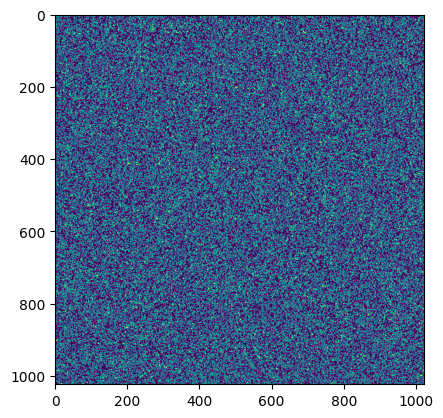

In [444]:
# Versión distribuida (4 workers para 4 nucleos, si tiene más núcleos puede crear manualmente más workers en el docker-compose)

from dask.distributed import Client, LocalCluster
client = Client("tcp://172.18.0.2:8786")
stride = np.int32(MAX_X / MAX_UNITS)
count = np.int32(0)
nodes = [] # arreglo que almacenará aquellos nodos que se ejecutan
for t in range(MAX_UNITS):
    node = delayed(conway)(count, np.int32(count + stride), t)
    nodes.append(node)
    count = count + stride

t1 = time()
results = client.compute(nodes)
results = client.gather(results)
sorted_results = sorted(results, key=lambda x: x[1])

sorted_data_lists = [result[0] for result in sorted_results]
vector_out = np.concatenate(sorted_data_lists)
    
t2 = time()
print(f"El tiempo que tomó calcular {t2 - t1}")
fig = plt.figure()
plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
plt.show()  
client.close()

/home/codespace/.python/current/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37223 instead
  warnings.warn(


El tiempo que tomó calcular 11.935571432113647


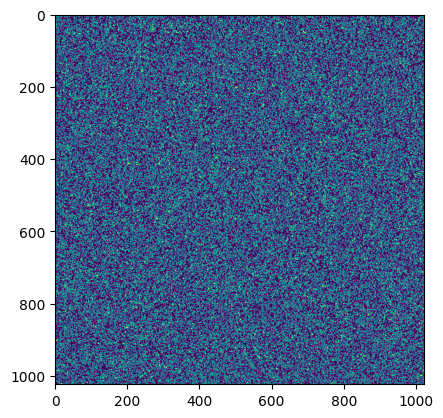

In [445]:
# Usando multiprocessing de Dask

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=True)  # Utiliza todos los núcleos disponibles
client = Client(cluster)
stride = np.int32(MAX_X / MAX_UNITS)
count = np.int32(0)
nodes = [] # arreglo que almacenará aquellos nodos que se ejecutan
for t in range(MAX_UNITS):
    node = delayed(conway)(count, np.int32(count + stride), t)
    nodes.append(node)
    count = count + stride

t1 = time()
results = client.compute(nodes)
results = client.gather(results)
sorted_results = sorted(results, key=lambda x: x[1])

sorted_data_lists = [result[0] for result in sorted_results]
vector_out = np.concatenate(sorted_data_lists)
    
t2 = time()
print(f"El tiempo que tomó calcular {t2 - t1}")
fig = plt.figure()
plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
plt.show()  
client.close()